# Udacity Data Science Nanodegree Project 1 Term 2
## Write a Data Science Blog Post
### Seattle Airbnb Open Data

## Imports and own defined functions

In [1]:
# Packages
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
def char_eraser(string, character):
    """The functions takes a string, substracts the character passed as an argument and 
    returns the result as an int."""
    if pd.isna(string):
        value = np.nan
    else:
        value = float(string.replace(character, ''))
    
    return value

def price_converter(string):
    """The function takes a number formated as a string that ends with a dolar symbol ($) and erases the symbol. 
     the number has decimals delimited by a comma ',' it  
    """
    if isinstance(string, str):
        value = float(string.replace('$', '').replace(',', ''))
    else:
        value = string
    
    return value

def is_holidays(date):
    """Checks if the date is a Seattle holiday"""
    holidays_2016 = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', 
                     '2016-11-11', '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-01']
    
    if isinstance(date, pd.Timestamp):
        date = date.strftime('%Y-%m-%d')
    
    holiday = True if date in holidays_2016 else False
    
    return holiday

seasons = {1: 'Winter',
          2:'Spring',
          3:'Summer',
          4:'Fall'}

def get_season(date):
    """Maps to which season the date corresponds to."""
    if not isinstance(date, pd.datetime):
        date = pd.to_datetime(date)
        
    return seasons[date.quarter]

def ordered_barplot(df, x_column, y_column):
    df.sort_values(y_column, ascending=False, inplace=True)
    plt.figure(figsize=(15,10))
    plt.bar(df[x_column], df[y_column])
    plt.xticks(rotation=90)
    plt.title(y_column + ' by ' + x_column)
    plt.show()

In [3]:
pd.set_option('display.max_columns', 500)

## Exploratory Data Analysis

In [4]:
calendar = pd.read_csv('calendar_seattle.csv')
listings = pd.read_csv('listings_seattle.csv')

In [5]:
print(calendar.shape, listings.shape)

(1393570, 4) (3818, 92)


In [6]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
len(calendar.dropna()['listing_id'].unique()) # number of different rooms

3723

In [8]:
calendar['date'].apply([np.min, np.max])

amin    2016-01-04
amax    2017-01-02
Name: date, dtype: object

In [9]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

### Preprocess

In [10]:
calendar['price'] = calendar['price'].apply(price_converter)  # Formating price column to number
calendar['available'] = calendar['available'].apply(lambda x: False if x == 'f' else True)  # Formating available column to boolean
calendar['date'] = pd.to_datetime(calendar['date']) # Formating date
calendar['month'] = calendar['date'].apply(lambda x: x.month)
calendar['month_name'] = calendar['date'].apply(lambda x: x.month_name())
calendar['season'] = calendar['date'].apply(get_season)
calendar['day'] = calendar['date'].apply(lambda x: x.day)
calendar['is_holiday'] = calendar['date'].apply(is_holidays) 
calendar['weekday'] = calendar['date'].apply(lambda x: x.day_name())
calendar['is_friday_saturday'] = calendar['weekday'].apply(lambda x: 
                                                    True if x in ['Friday', 'Saturday'] else False)

Percentage of missing values per column:

In [11]:
(len(calendar) - calendar.apply('count'))/len(calendar)*100

listing_id             0.000000
date                   0.000000
available              0.000000
price                 32.938998
month                  0.000000
month_name             0.000000
season                 0.000000
day                    0.000000
is_holiday             0.000000
weekday                0.000000
is_friday_saturday     0.000000
dtype: float64

For our analysis we are going to focus on the listings that are available:

In [12]:
calendar.dropna(inplace=True)

In [13]:
listings_vars_to_merge = listings[['id', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 
                                   'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']]

In [14]:
# Merging calendar DataFrame with listings and listing_reviews
df = pd.merge(calendar, listings_vars_to_merge, left_on='listing_id', right_on='id', how='left')
df.drop(['available', 'id'], axis=1, inplace=True)
# df = pd.merge(df, listings_reviews, left_on='listing_id', right_on='id')
# df.drop(['available', 'id_x', 'id_y', 'is_friday_saturday'], axis=1, inplace=True)
df['bathrooms'] = np.around(df['bathrooms'])

In [15]:
(len(df) - df.apply('count'))/len(df)*100

listing_id                      0.000000
date                            0.000000
price                           0.000000
month                           0.000000
month_name                      0.000000
season                          0.000000
day                             0.000000
is_holiday                      0.000000
weekday                         0.000000
is_friday_saturday              0.000000
neighbourhood_group_cleansed    0.000000
property_type                   0.033064
room_type                       0.000000
accommodates                    0.000000
bathrooms                       0.513942
bedrooms                        0.214330
beds                            0.039057
bed_type                        0.000000
dtype: float64

In [16]:
df.dropna(inplace=True)

In [49]:
df[['']].corrwith(df['price']).reset_index()

,index,0
0,listing_id,-0.051273
1,price,1.000000
2,month,0.042234
3,day,0.001035
4,is_holiday,0.000004
5,is_friday_saturday,0.030723
6,accommodates,0.676077
7,bathrooms,0.485868
8,bedrooms,0.632705
9,beds,0.610059


In [17]:
# Creating a DataFrame with average reviews rating by neighbourhood
neighborhood_ratings = listings.groupby('neighbourhood_group_cleansed')[['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                             'review_scores_value']].agg([np.mean]).reset_index()

In [18]:
neighborhood_ratings.columns = ['neighbourhood', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                        'review_scores_value']

In [19]:
neighborhood_ratings_melted = pd.melt(neighborhood_ratings, id_vars='neighbourhood').dropna()

In [20]:
neighborhood_ratings_melted.loc[neighborhood_ratings_melted['variable']=='review_scores_rating', 'value'] = neighborhood_ratings_melted.loc[neighborhood_ratings_melted['variable']=='review_scores_rating', 'value'] / 10.0

## Data Visualization

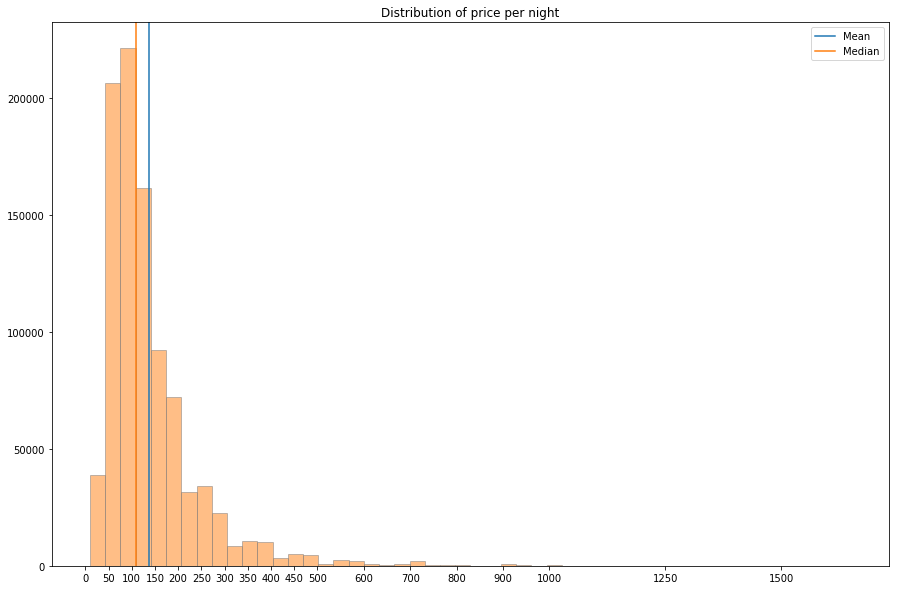

In [21]:
plt.figure(figsize=(15,10))
plt.hist(calendar['price'], bins=50, edgecolor='gray', color='C1', alpha=0.5)
plt.title('Distribution of price per night')
plt.xticks(list(range(0,501, 50)) + list(range(600,1001,100)) + [1250, 1500])
plt.axvline(x=calendar['price'].mean(), color='C0', label='Mean')
plt.axvline(x=calendar['price'].median(), color='C1', label='Median')
plt.legend()
plt.show()

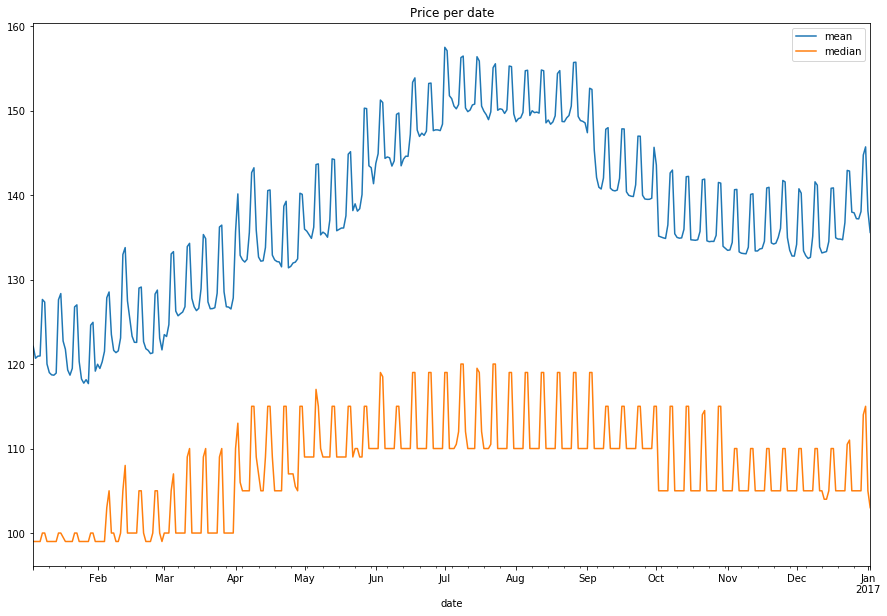

In [22]:
calendar.groupby('date')['price'].agg(['mean', 'median']).plot(figsize=(15,10),
                                                              title='Price per date')

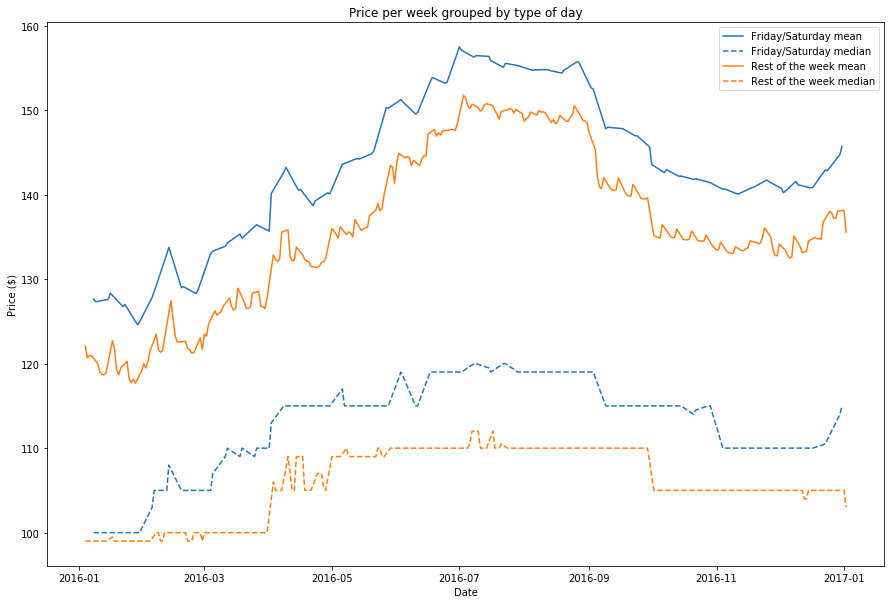

In [23]:
plt.figure(figsize=(15,10))
for pos, is_weekend in enumerate([True, False]):
    week_dict = {True: 'Friday/Saturday',
                False: 'Rest of the week'}
    filt = calendar[calendar['is_friday_saturday']  == is_weekend].groupby('date')['price'].agg(['mean', 'median'])
    plt.plot(filt.index, filt['mean'], color='C'+str(pos), label= week_dict[is_weekend] + ' mean')
    plt.plot(filt.index, filt['median'], color='C'+str(pos), linestyle='--', 
             label= week_dict[is_weekend] + ' median')
    plt.title('Price per week grouped by type of day')
    plt.ylabel('Price ($)')
    plt.xlabel('Date')
    plt.legend()
plt.show()

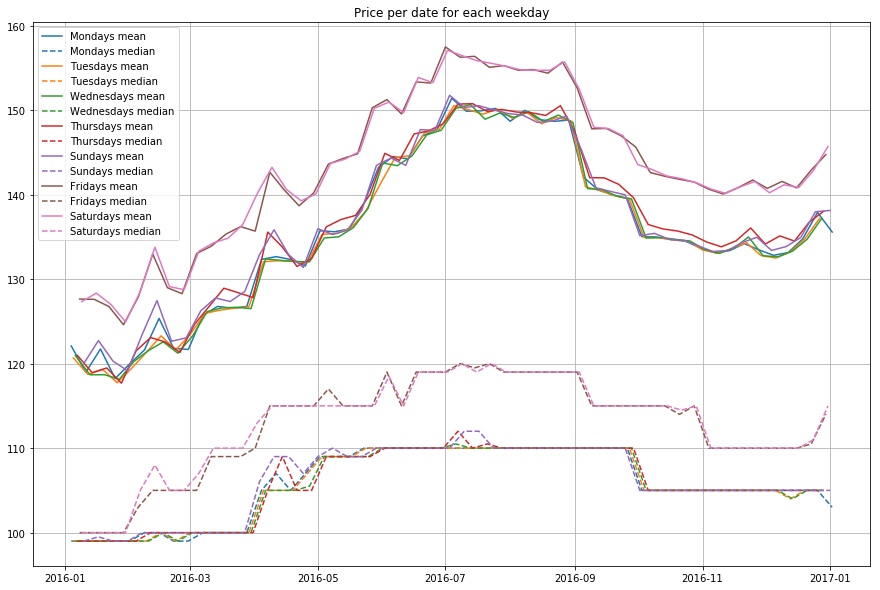

In [24]:
plt.figure(figsize=(15,10))
for pos, weekday in enumerate(calendar['weekday'].unique()):
    filt = calendar[calendar['weekday']  == weekday].groupby('date')['price'].agg(['mean', 'median'])
    plt.plot(filt.index, filt['mean'], color='C'+str(pos), label=weekday + 's mean')
    plt.plot(filt.index, filt['median'], color='C'+str(pos), linestyle='--', label=weekday + 's median')
    plt.legend()
plt.title('Price per date for each weekday')
plt.grid()
plt.show()

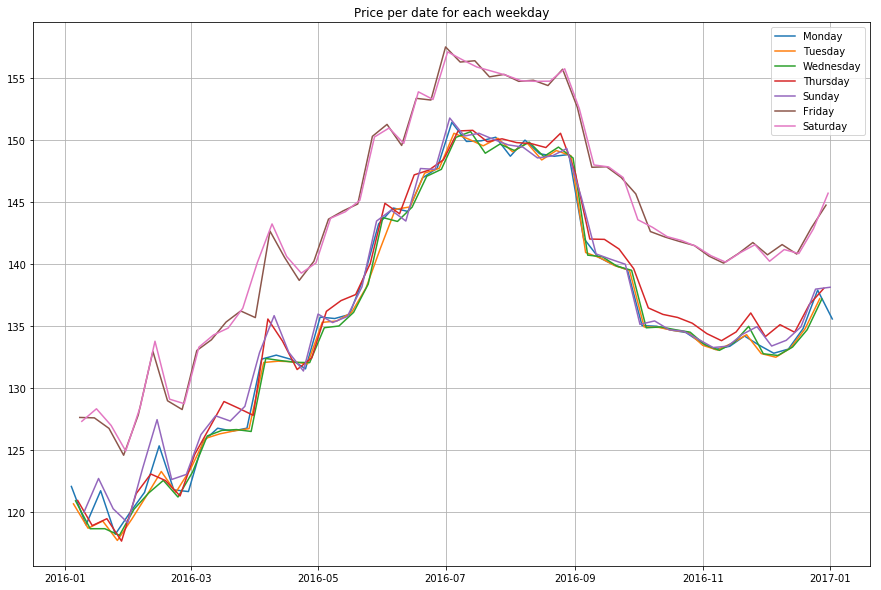

In [25]:
plt.figure(figsize=(15,10))
for pos, weekday in enumerate(calendar['weekday'].unique()):
    filt = calendar[calendar['weekday']  == weekday].groupby('date')['price'].agg(np.mean)
    plt.plot(filt.index, filt, color='C'+str(pos), label=weekday)
    plt.legend()
plt.title('Price per date for each weekday')
plt.grid()
plt.show()

In [26]:
calendar.groupby(['is_friday_saturday', 'month'])['price'].agg([np.mean, np.median, np.min, np.max])

mean  median  amin    amax
is_friday_saturday month                                  
False              1      121.614950    99.0  12.0  1000.0
                   2      122.237184    99.0  20.0  1000.0
                   3      126.553807   100.0  20.0  1099.0
                   4      132.604383   105.0  20.0  1099.0
                   5      137.369833   109.0  20.0  1099.0
                   6      145.875586   110.0  20.0  1099.0
                   7      150.217932   110.0  20.0  1199.0
                   8      149.167829   110.0  20.0  1250.0
                   9      141.042093   110.0  20.0  1450.0
                   10     134.905796   105.0  20.0  1650.0
                   11     133.824181   105.0  10.0  1650.0
                   12     134.909631   105.0  20.0  1650.0
True               1      126.696568   100.0  20.0  1000.0
                   2      129.760002   105.0  20.0  1000.0
                   3      134.673345   109.0  20.0  1099.0
                   4      140.044871   115.0  20.0  1099.0
                   5      145.776130   115.0  20.0  1099.0
                   6      151.902804   119.0  20.0  1099.0
                   7      156.050427   119.0  20.0  1240.0
                   8      154.937513   119.0  20.0  1250.0
                   9      148.428559   115.0  20.0  1450.0
                   10     142.228141   115.0  20.0  1650.0
                   11     140.819479   110.0  20.0  1650.0
                   12     142.165605   110.0  20.0  1650.0

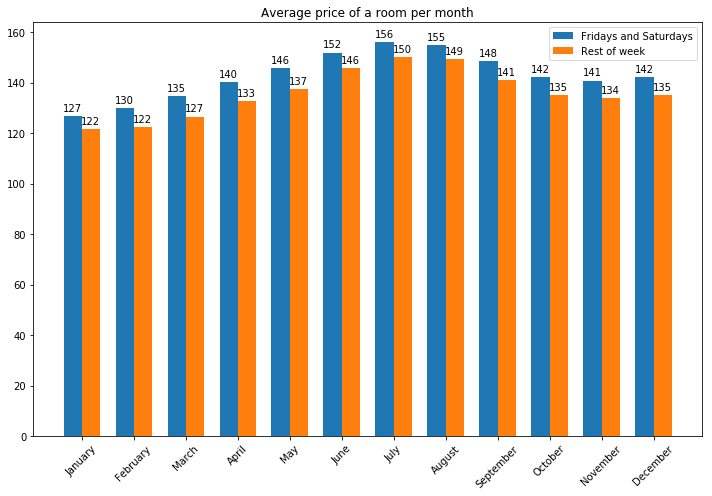

In [27]:
months = dict(zip(calendar['month'], calendar['month_name']))

grouped_data = calendar.groupby(['is_friday_saturday', 'month'])['price'].mean().reset_index()
labels = [months[month] for month in grouped_data['month'].unique()]

x = np.arange(len(grouped_data)/2)
width = 0.35

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, grouped_data[grouped_data['is_friday_saturday']==True]['price'], width,
               label='Fridays and Saturdays')
rects2 = ax.bar(x + width/2, grouped_data[grouped_data['is_friday_saturday']==False]['price'], width,
                label='Rest of week')

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Average price of a room per month')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(np.around(height))),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

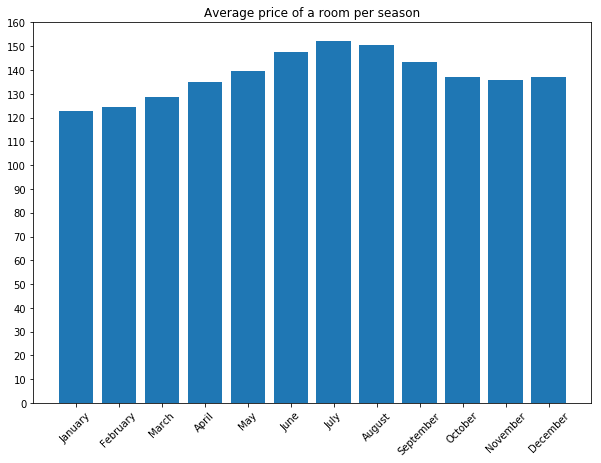

In [28]:
grouped_data = calendar.groupby('month')['price'].mean()
labels = [months[month] for month in grouped_data.index]

plt.figure(figsize=(10,7))
plt.bar(grouped_data.index, grouped_data)
plt.title('Average price of a room per season')
plt.xticks(ticks = grouped_data.index, labels=labels, rotation = 45)
plt.yticks(range(0,170,10))
plt.show()

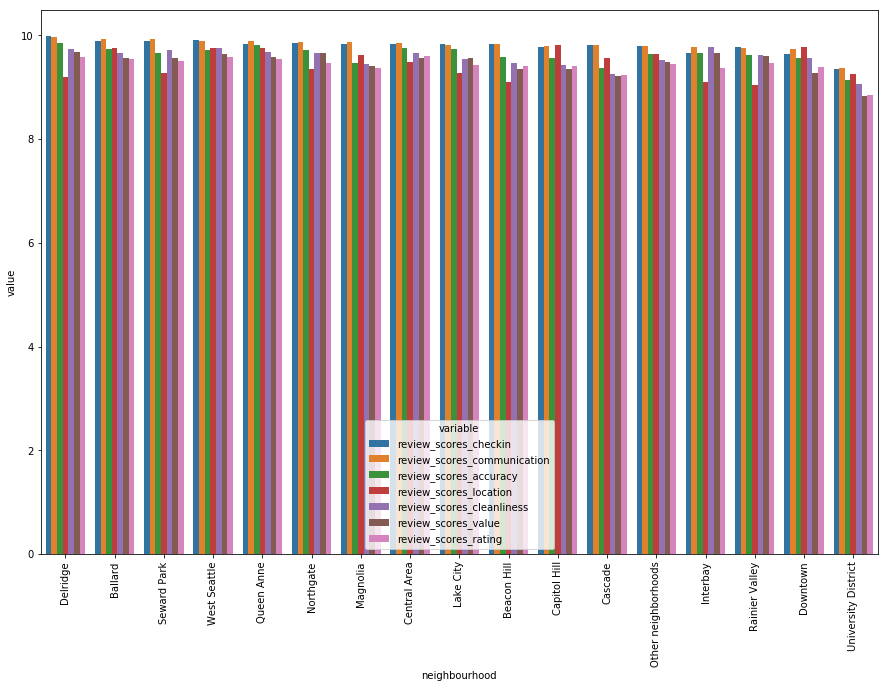

In [29]:
plt.figure(figsize=(15,10))
sns.barplot(x='neighbourhood', y='value', data=neighborhood_ratings_melted.sort_values('value', ascending=False),
            hue= 'variable')
plt.xticks(rotation=90)
plt.show()

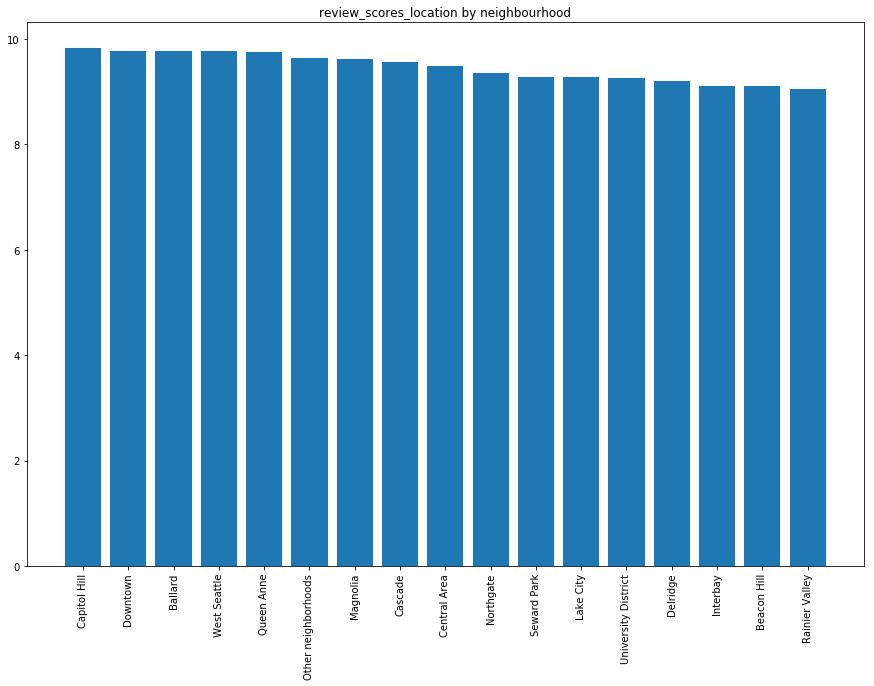

In [30]:
ordered_barplot(neighborhood_ratings, 'neighbourhood', 'review_scores_location')

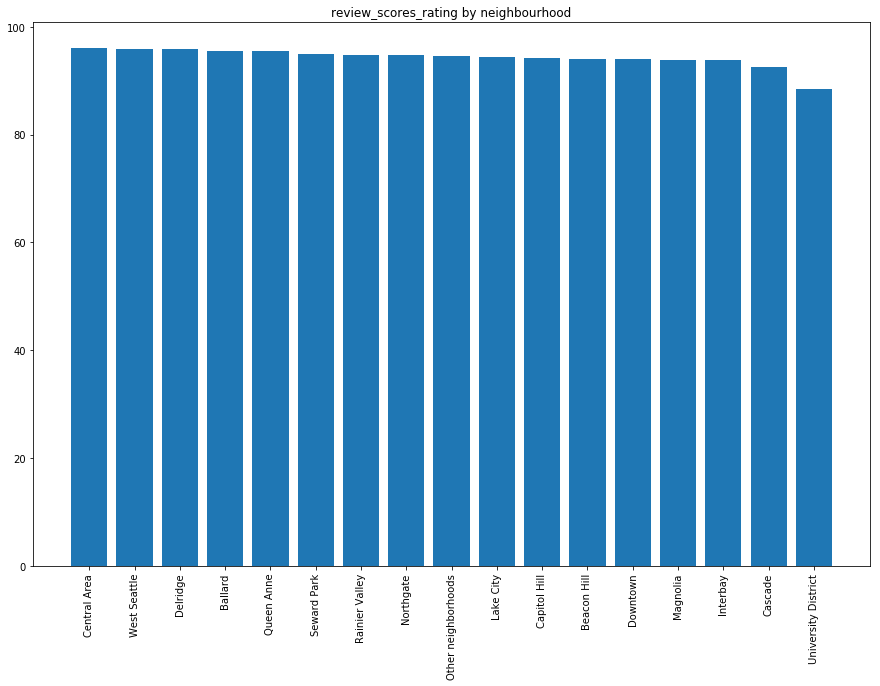

In [31]:
ordered_barplot(neighborhood_ratings, 'neighbourhood', 'review_scores_rating')

In [38]:
price_by_neighbourhood = df.groupby('neighbourhood_group_cleansed')['price'].agg(
    np.mean).reset_index().sort_values('price', ascending=False)

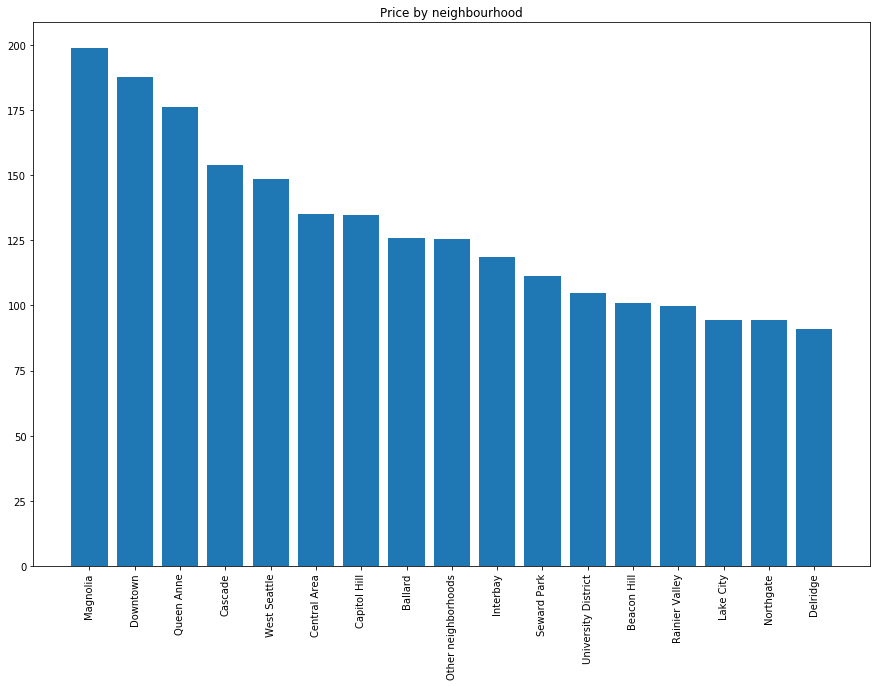

In [40]:
plt.figure(figsize=(15,10))
plt.bar(price_by_neighbourhood['neighbourhood_group_cleansed'], 
       price_by_neighbourhood['price'])
plt.xticks(rotation=90)
plt.title('Price by neighbourhood')
plt.show()

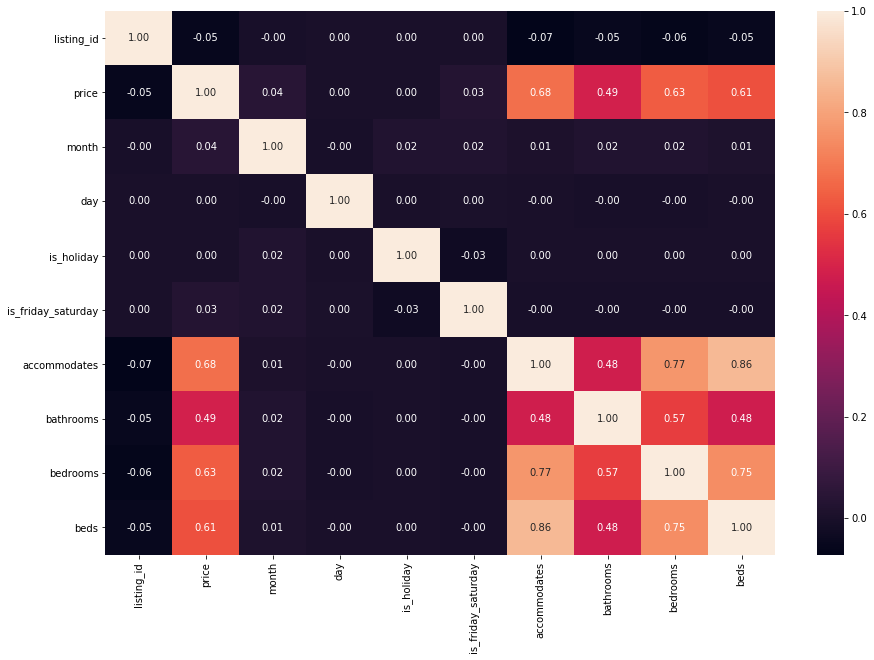

In [46]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

## Modelling

In [42]:
df.columns

Index(['listing_id', 'date', 'price', 'month', 'month_name', 'season', 'day',
       'is_holiday', 'weekday', 'is_friday_saturday',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type'],
      dtype='object')

In [43]:
X = df[['month_name', 'is_holiday', 'weekday', 'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']]
Y = df['price']

ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2)

### Linear Regression

In [44]:
lm = LinearRegression(normalize=True)
lm.fit(X_train, Y_train)
Y_pred_lm = lm.predict(X_test)
print(r2_score(Y_test, Y_pred_lm))
print(np.sqrt(mean_squared_error(Y_test, Y_pred_lm)))

0.6310880190719323
63.72552277043155


### Random Forest

In [67]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=200, min_samples_leaf=500)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
print(r2_score(Y_test, Y_pred))
print(np.sqrt(mean_squared_error(Y_test, Y_pred)))

0.710688990470578
56.61640404438383


### Feature Importance

In [68]:
feature_importance = pd.DataFrame.from_dict(dict(zip(pd.get_dummies(X).columns, rf.feature_importances_)), orient='index')
feature_importance.columns = ['feature_importance']

In [69]:
feature_importance.sort_values('feature_importance', ascending=False, inplace=True)

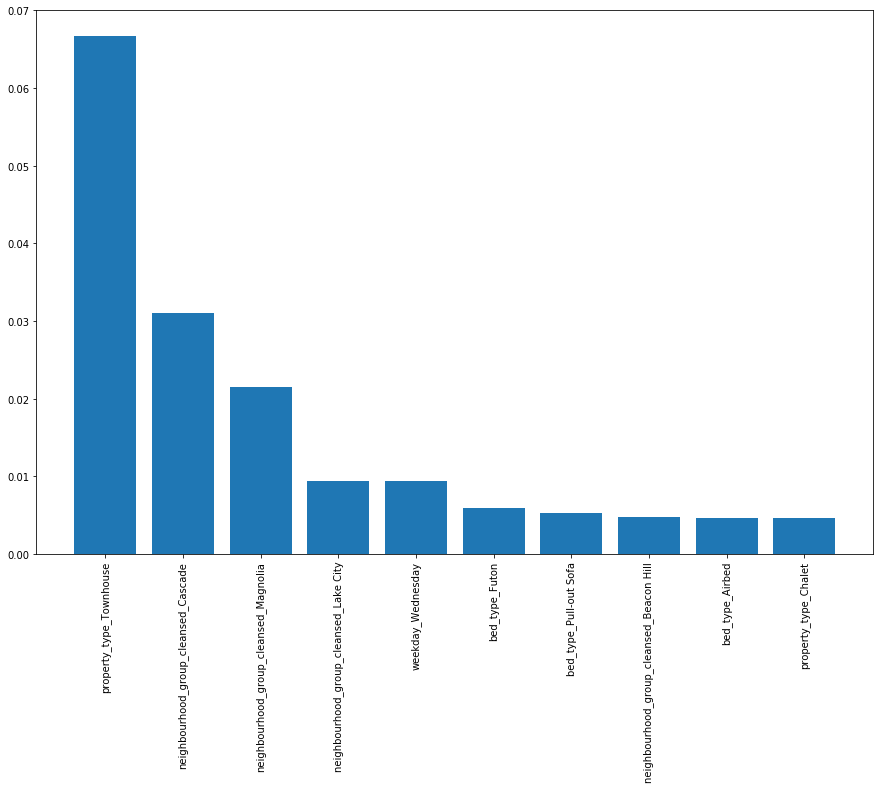

In [70]:
plt.figure(figsize=(15,10))
plt.bar(feature_importance.index[:10], feature_importance['feature_importance'][:10])
plt.xticks(rotation=90)
plt.show()

### Error Exploration

In [75]:
df['predicted_price'] = rf.predict(X_encoded)
df['error'] = df['price'] - df['predicted_price']
df['abs_error'] = np.abs(df['price'] - df['predicted_price'])

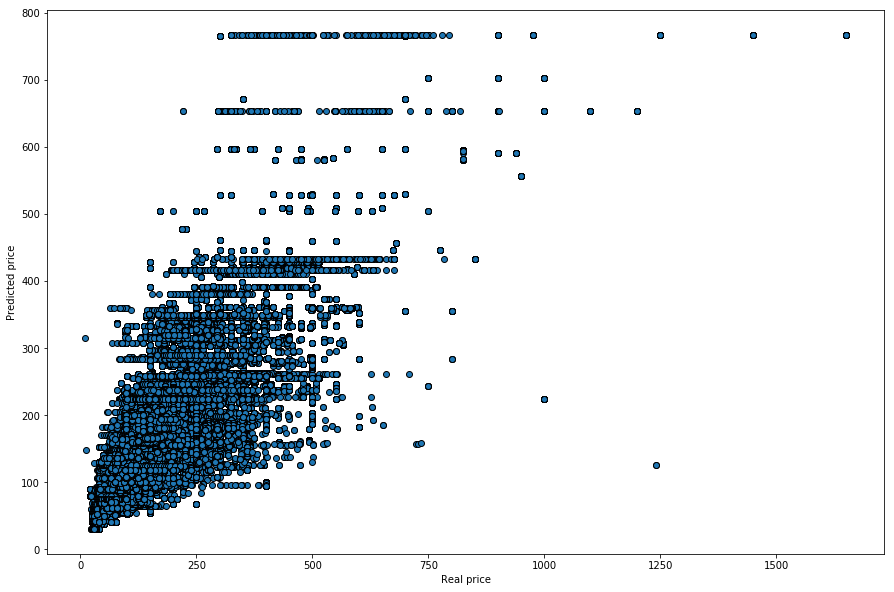

In [76]:
plt.figure(figsize=(15,10))
plt.scatter(df['price'], df['predicted_price'], edgecolors='black')
plt.xlabel('Real price')
plt.ylabel('Predicted price')
plt.show()

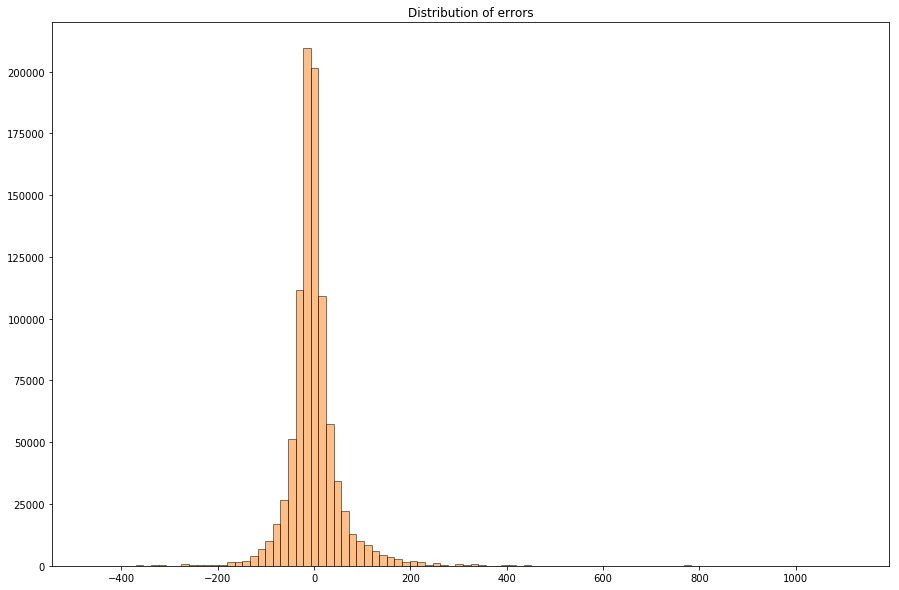

In [77]:
plt.figure(figsize=(15,10))
plt.hist(df['error'], bins = 100, edgecolor='black', color='C1', alpha=0.5)
plt.title('Distribution of errors')
plt.show()

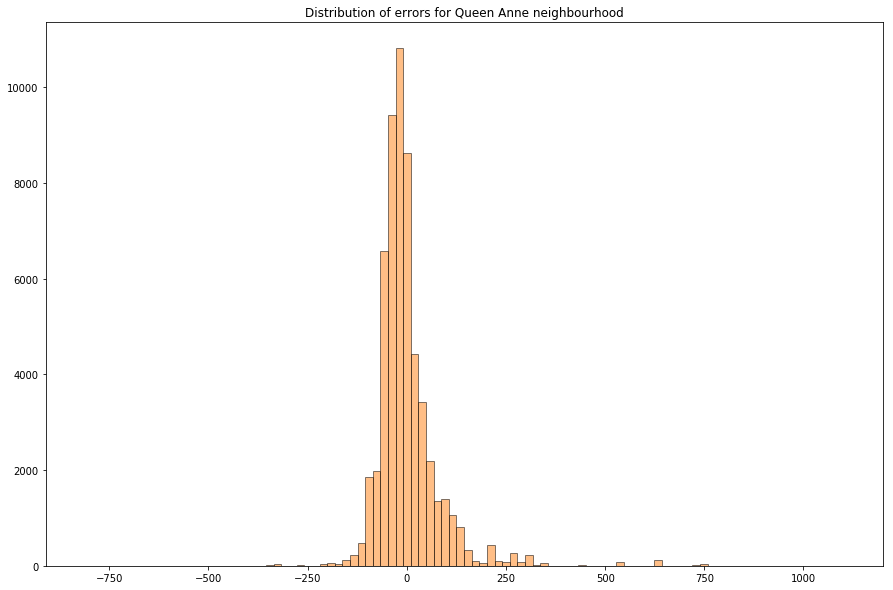

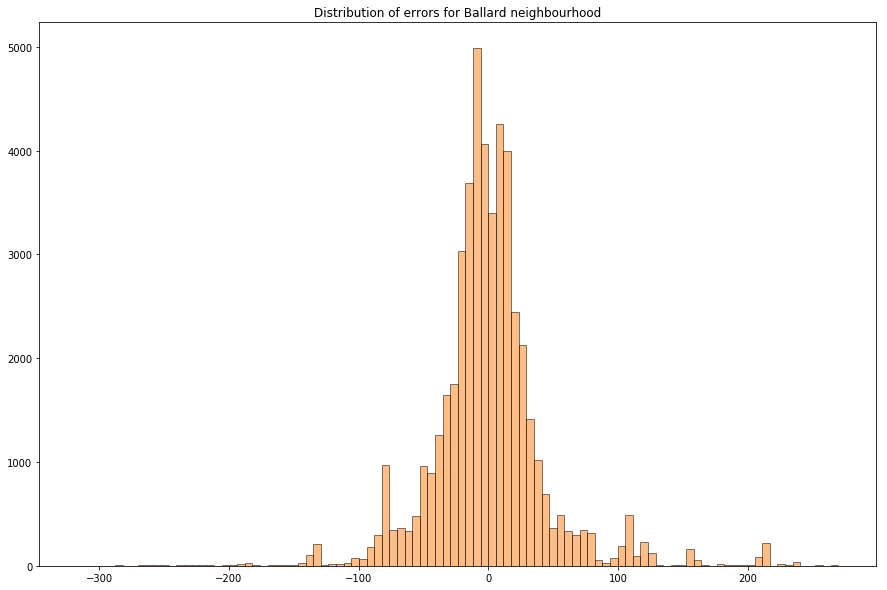

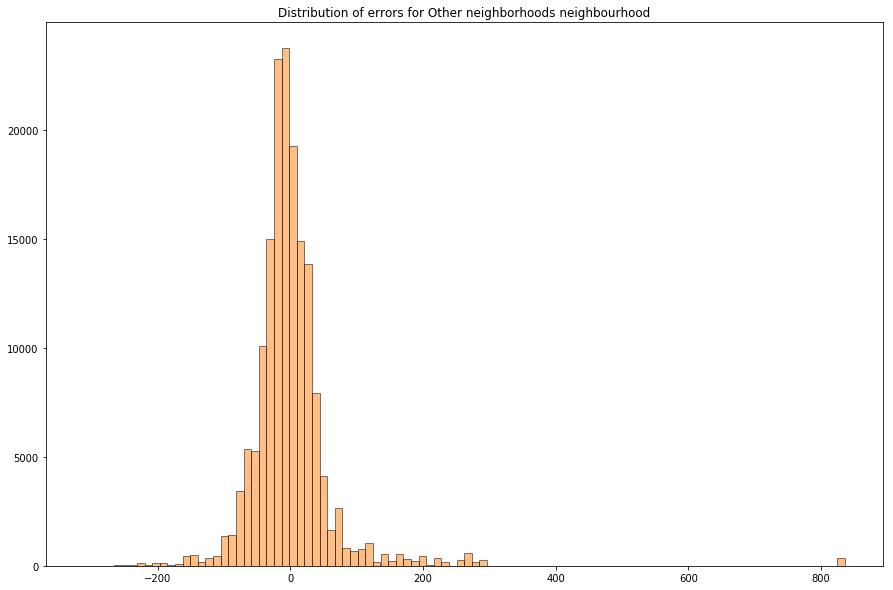

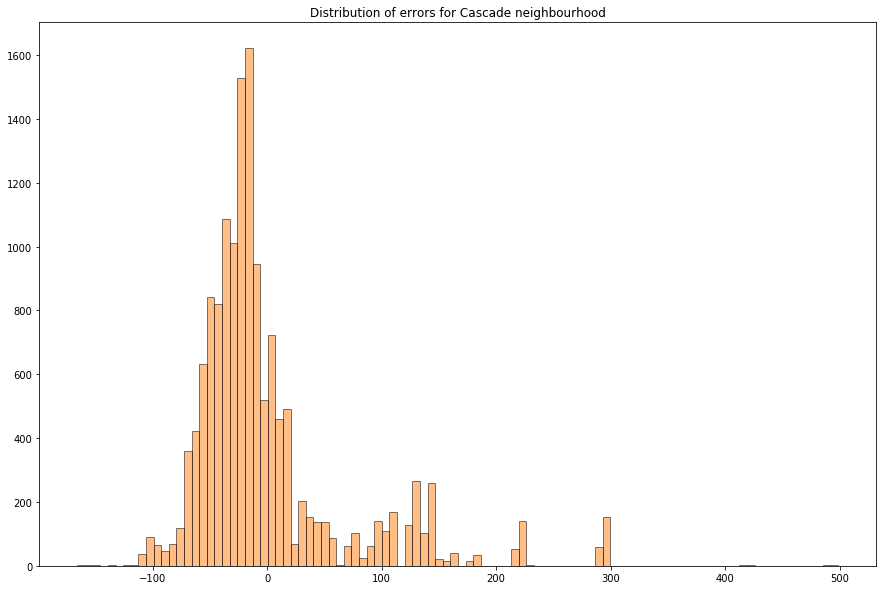

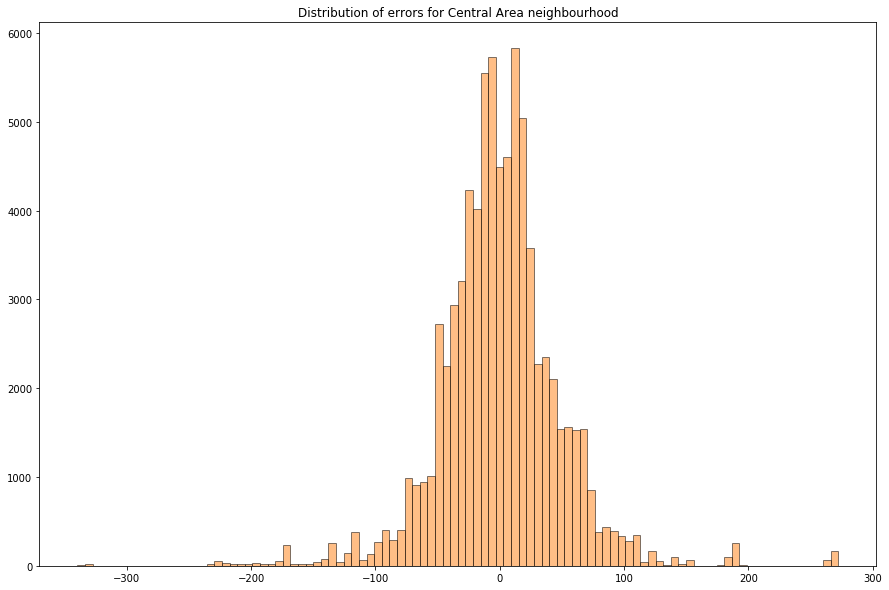

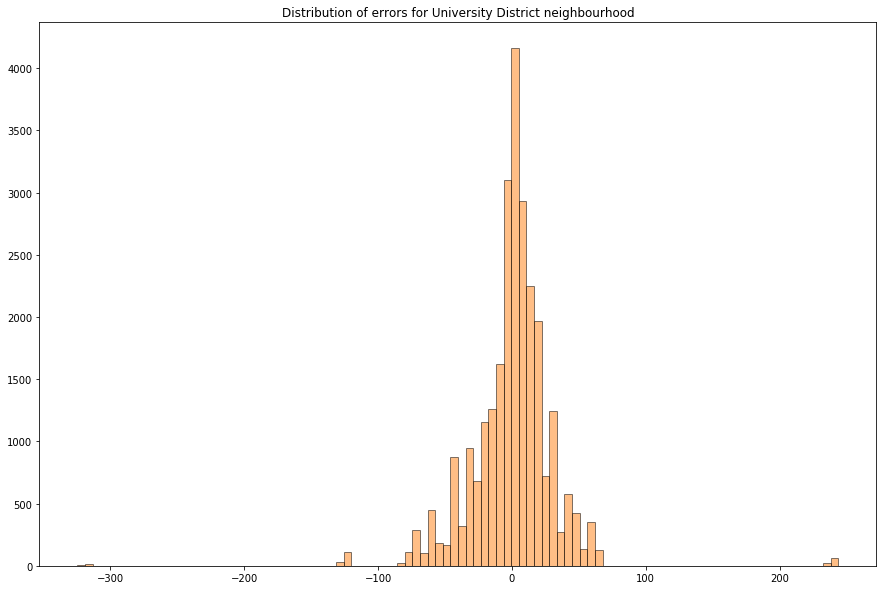

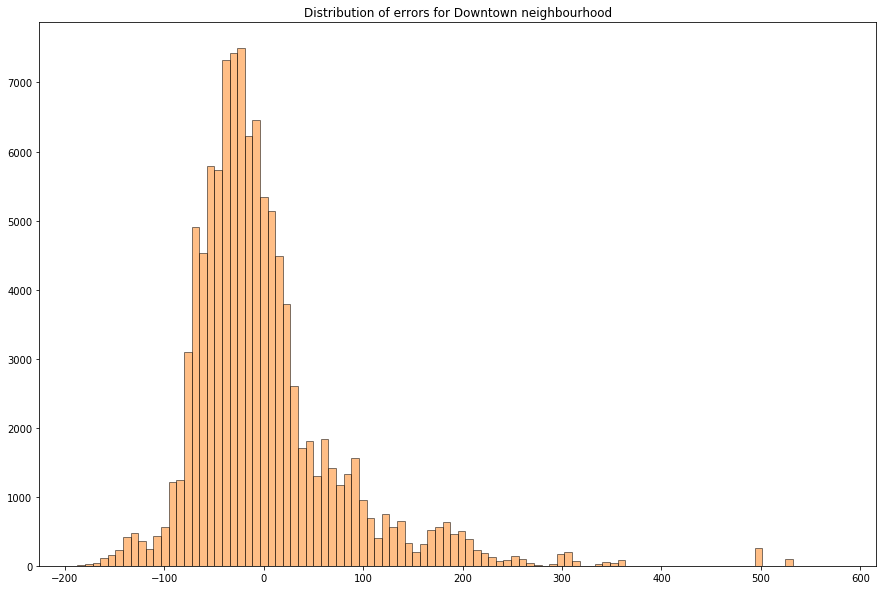

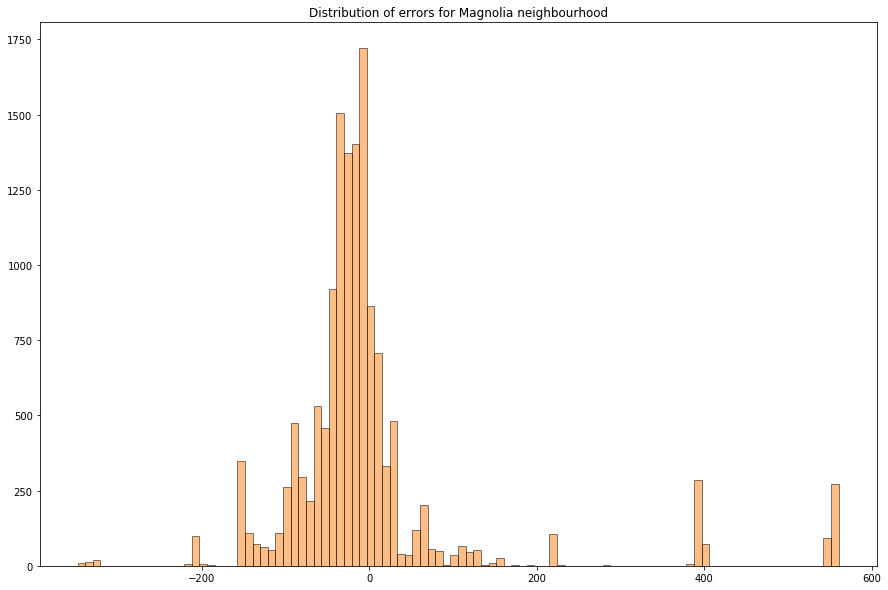

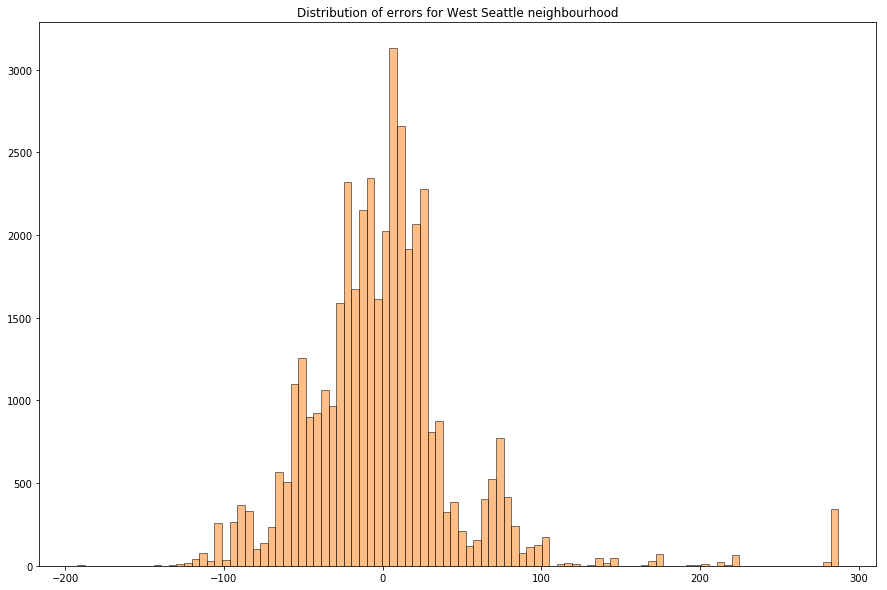

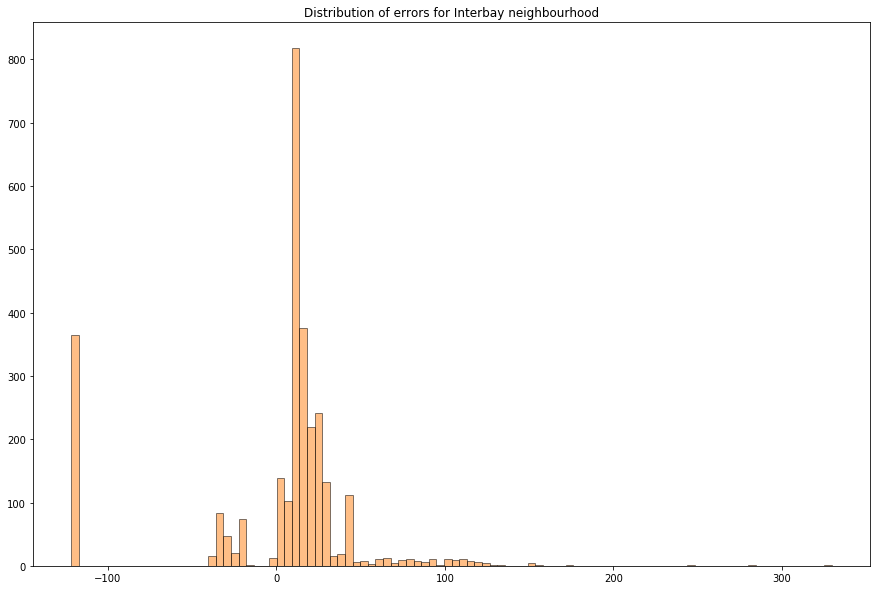

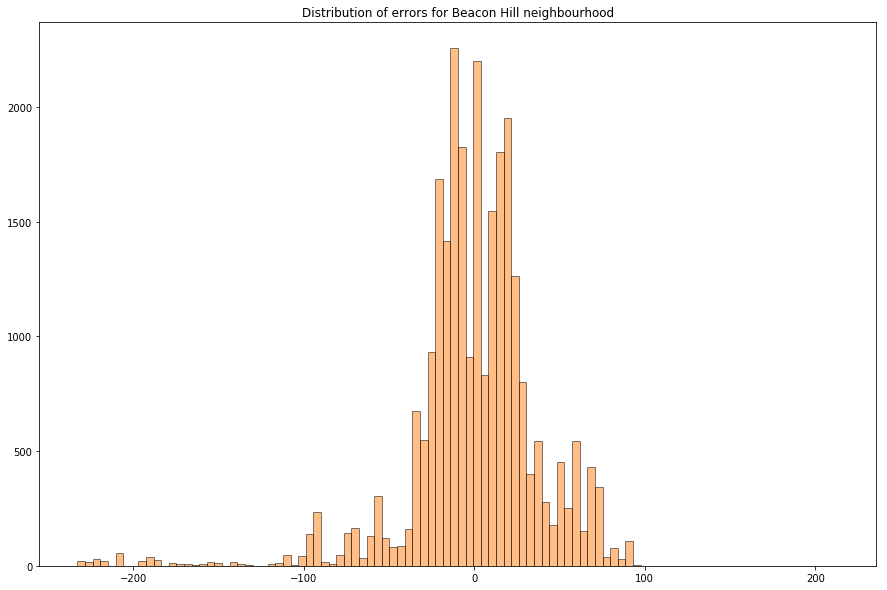

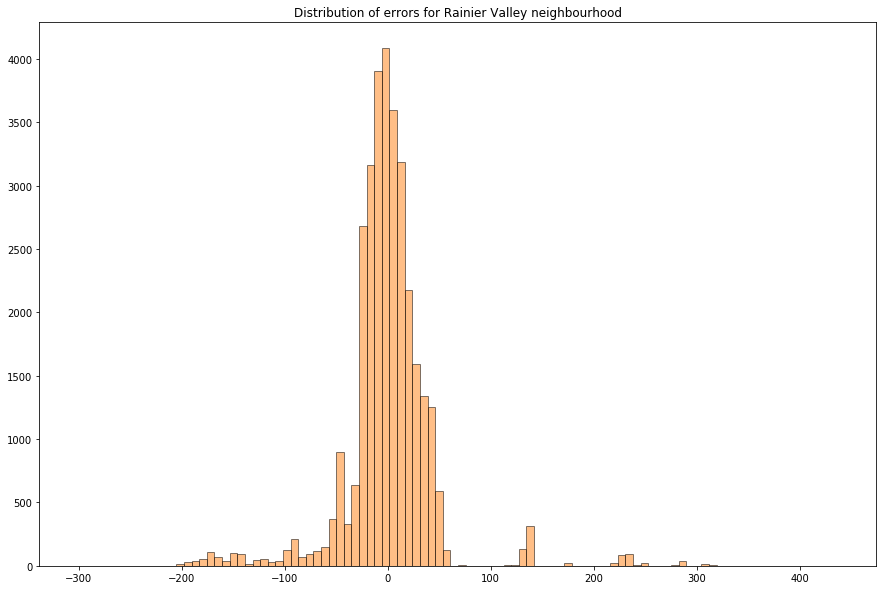

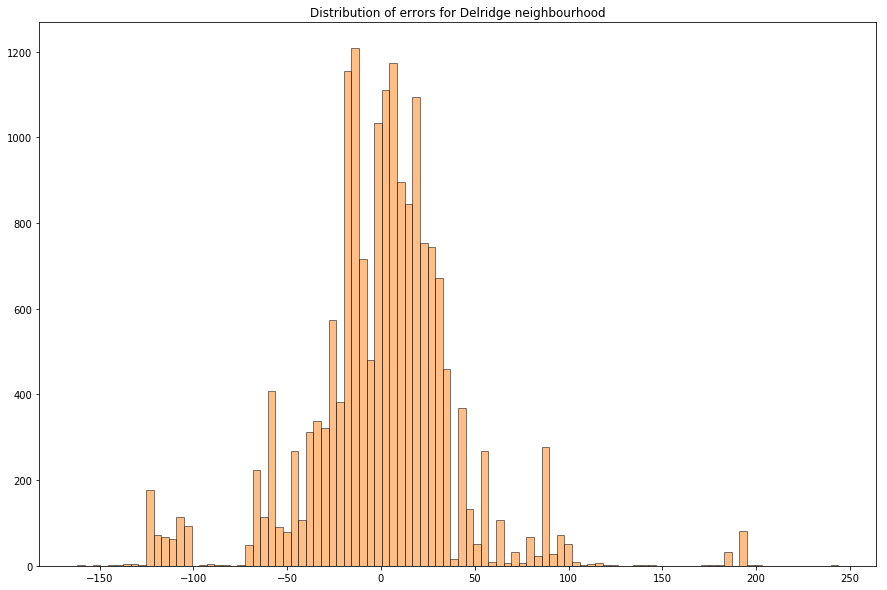

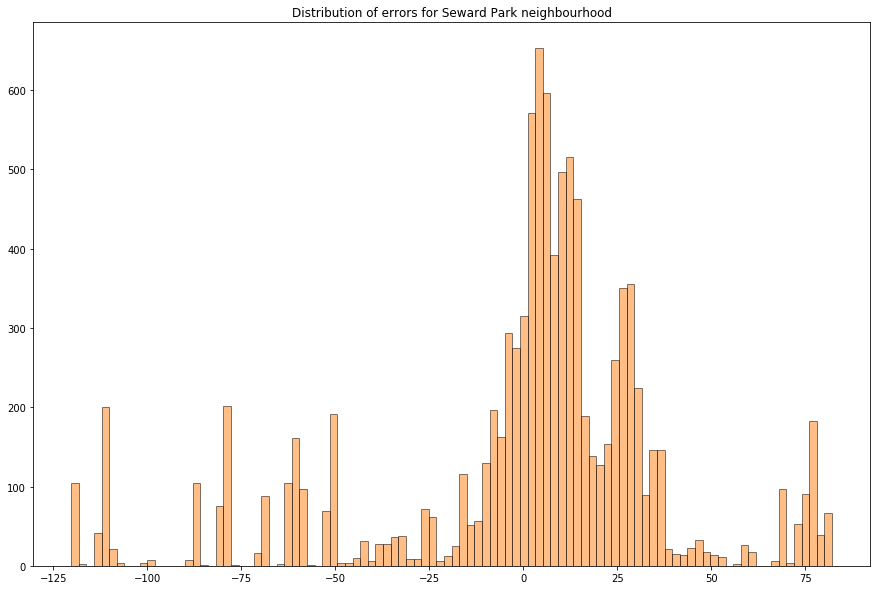

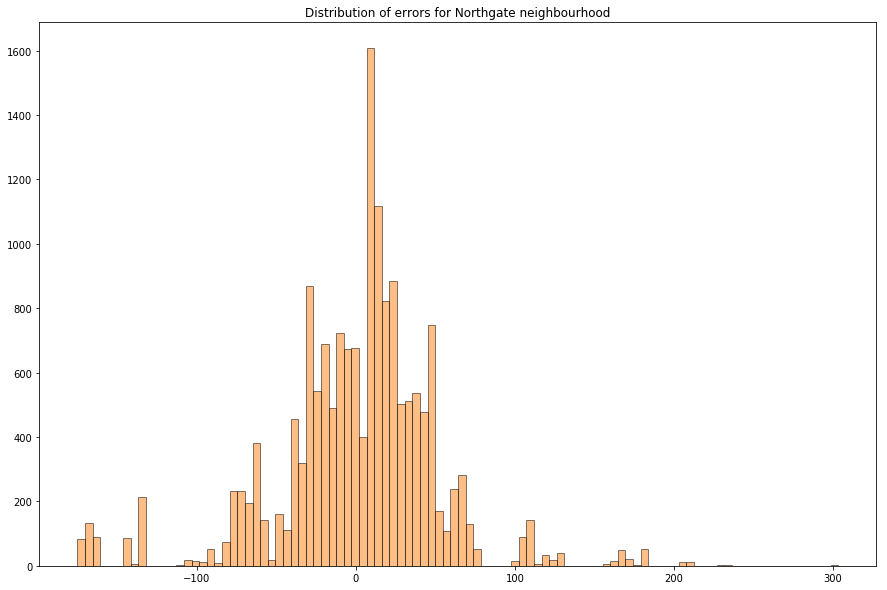

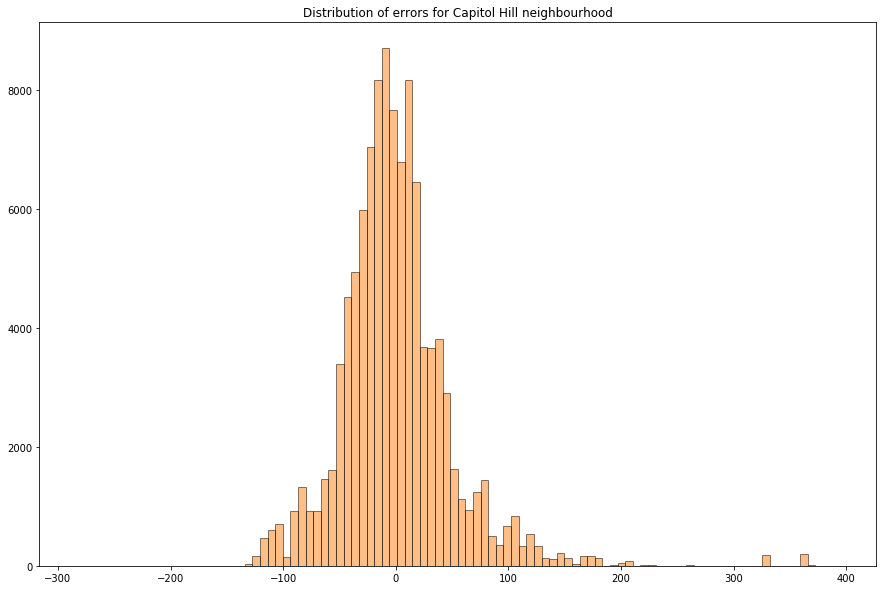

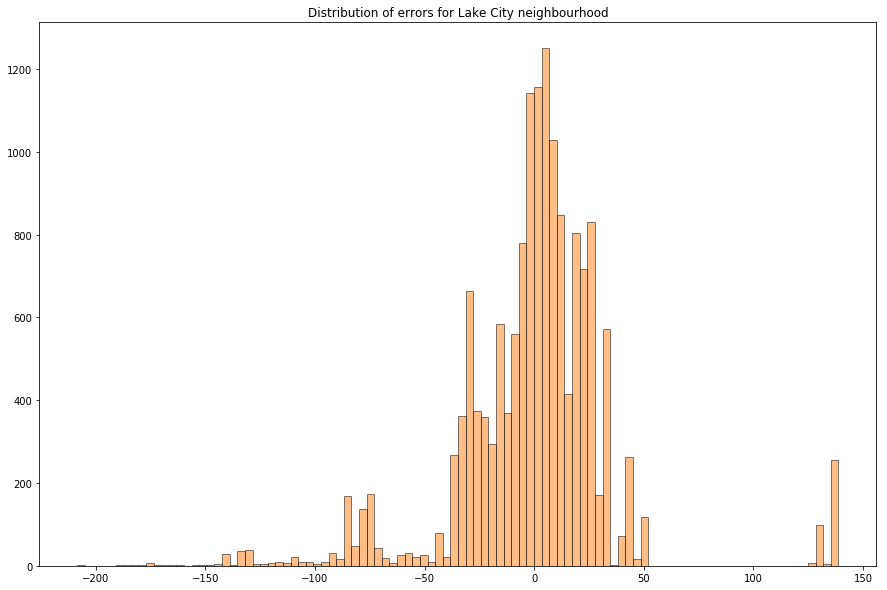

In [41]:
for neighbourhood in df['neighbourhood_group_cleansed'].unique():
    plt.figure(figsize=(15,10))
    filt = df[df['neighbourhood_group_cleansed']==neighbourhood]
    plt.hist(filt['error'], bins = 100, edgecolor='black', color='C1', alpha=0.5)
    plt.title('Distribution of errors for '+ neighbourhood + ' neighbourhood')
    plt.show()

In [78]:
df.groupby('neighbourhood_group_cleansed')['abs_error'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Ballard,58115.0,29.000139,39.799233,0.007800,7.202948,16.956355,31.078480,446.639881
Beacon Hill,29914.0,23.844604,29.711785,0.033182,7.068245,15.975253,28.253620,208.746380
Capitol Hill,130907.0,30.474593,35.575397,0.000177,9.634839,20.146494,39.878177,418.240503
Cascade,18717.0,47.513696,66.939943,0.026145,10.946281,28.362996,48.053952,515.812246
Central Area,90556.0,31.269444,33.895603,0.005799,9.833503,21.024870,40.160704,464.714941
Delridge,21545.0,24.448006,29.859651,0.018704,7.007800,16.068548,28.229177,193.962098
Downtown,123861.0,44.712097,48.939312,0.000179,14.679067,30.358353,55.908019,575.056873
Interbay,3394.0,34.514254,26.786945,0.055833,14.007800,26.646323,44.901997,271.055833
Lake City,18801.0,22.096155,25.840696,0.164331,6.851331,14.575257,26.209199,238.472644


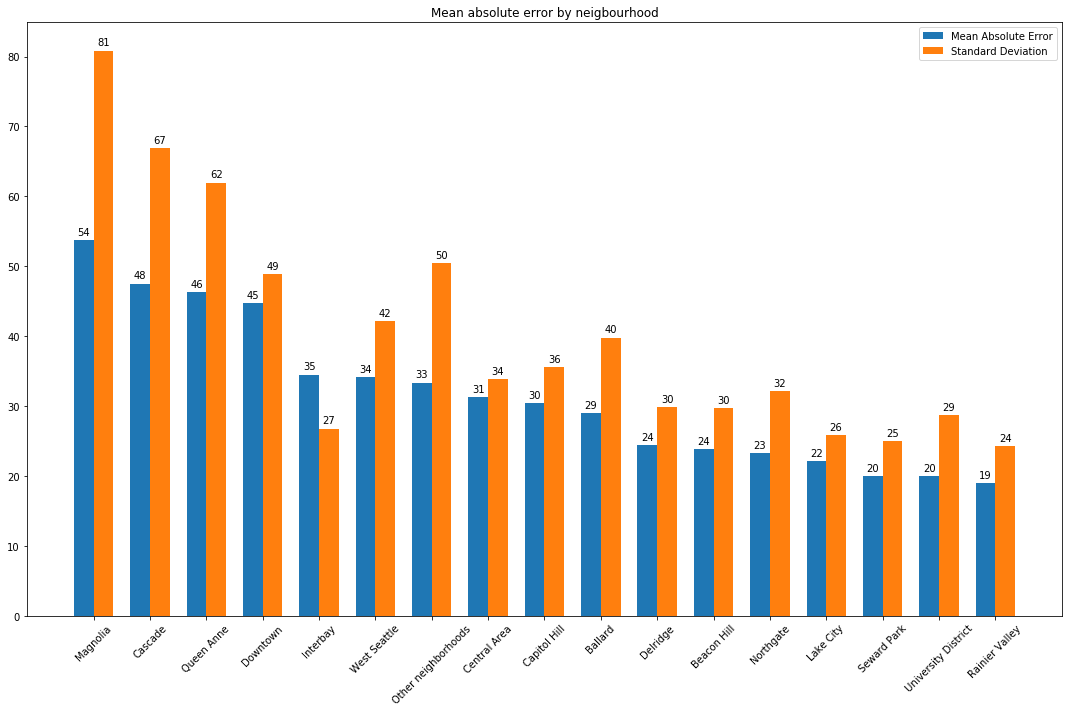

In [79]:
error_statistics_by_neighbourhood = df.groupby('neighbourhood_group_cleansed')['abs_error'].describe()
error_statistics_by_neighbourhood.sort_values('mean', ascending=False, inplace=True)

x = np.arange(len(error_statistics_by_neighbourhood))
width = 0.35

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, error_statistics_by_neighbourhood['mean'], width,
                label='Mean Absolute Error')
rects2 = ax.bar(x + width/2, error_statistics_by_neighbourhood['std'], width,
                label='Standard Deviation')

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(error_statistics_by_neighbourhood.index, rotation=45)
ax.set_title('Mean absolute error by neigbourhood')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(np.around(height))),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()